In [16]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from sklearn import svm

species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# grab behavioral data, spike data, trial numbers. 

fs = s3fs.S3FileSystem()

behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])]
trial_numbers = np.unique(valid_beh.TrialNumber)
spike_data = spike_general.get_spike_times_by_trial(fs, subject, session, trial=trial_numbers, start_field="TrialStart", end_field="TrialEnd")    


In [89]:
trial_lengths = valid_beh.TrialEnd - valid_beh.TrialStart
pre = valid_beh.FeedbackOnset - valid_beh.TrialStart
post = valid_beh.TrialEnd - valid_beh.FeedbackOnset
print(min(pre))
print(min(post))

1501.0
1499.0


In [5]:
# find "fixation times". In this case, 800ms before feedback. 
pre_interval = 800
post_interval = 0
intervals = behavioral_utils.get_trial_intervals(valid_beh, "FeedbackOnset", pre_interval, post_interval)

In [ ]:
# find the spikes falling in the intervals
spike_times = spike_general.get_spike_times(fs, subject, session)
spike_by_trial_interval = spike_utils.get_spikes_by_trial_interval(spike_times, intervals)

In [32]:
# grab firing rates, spike counts, in 800ms intervals, 100ms bins
firing_rates = spike_analysis.firing_rate(spike_by_trial_interval, bins=np.arange(0, 0.9, 0.1), smoothing=1)

In [88]:
# grab Shape, Color, Pattern features for each selection
selections = behavioral_utils.get_selection_features(valid_beh)

In [3]:
# load what's already been computed
feature_selections = pd.read_pickle("../data/feature_selections.pickle")
firing_rates = pd.read_pickle("../data/firing_rates.pickle")

In [62]:
# use a support vector machine model
clf = svm.SVC(decision_function_shape='ovo')

# Look at Spike Counts instead of Firing Rate
mode = "SpikeCounts"

# Look at 'Pattern' as a dimension
feature_dim = "Pattern"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = feature_selections.rename(columns={feature_dim: "Feature"})


In [64]:
# randomly grab trials for train/test, run 20 times, split 80/20
random_splitter = RandomSplitter(labels.TrialNumber.unique(), 20, 0.2)
train_accs, test_accs, shuffled_accs, models = classifier_utils.evaluate_classifier(clf, inputs, labels, random_splitter)
print(f"Mean Train accuracy: {np.mean(train_accs)}, Test accuracy: {np.mean(test_accs)}, Shuffled accuracy: {np.mean(shuffled_accs)}")


In [ ]:
# split trials into train/test by blocks, always leave one block out for test. 
block_splitter = BlockSplitter(valid_beh)
train_accs, test_accs, shuffled_accs, models = classifier_utils.evaluate_classifier(clf, inputs, labels, block_splitter)

In [ ]:
# look across different time bins, evaluate classifier on each time bin individually
time_bins = np.arange(0.0, 0.8, 0.1)
for bin in time_bins:
    inputs_for_bin = inputs[inputs["TimeBins"] == bin]
    train_accs, test_accs, shuffled_accs, models = classifier_utils.evaluate_classifier(clf, inputs_for_bin, labels, random_splitter)
    print(f"Mean Train accuracy: {np.mean(train_accs)}, Test accuracy: {np.mean(test_accs)}, Shuffled accuracy: {np.mean(shuffled_accs)}")

In [4]:
# find "fixation times". In this case, 800ms before feedback. 
pre_interval = 1200
post_interval = 800
intervals = behavioral_utils.get_trial_intervals(valid_beh, "FeedbackOnset", pre_interval, post_interval)

In [5]:
# find the spikes falling in the intervals
spike_times = spike_general.get_spike_times(fs, subject, session)
spike_by_trial_interval = spike_utils.get_spikes_by_trial_interval(spike_times, intervals)

In [7]:
spike_by_trial_interval.to_pickle("../data/spike_by_trial_interval_1200_fb_800.pickle")

In [22]:
spike_by_trial_interval = pd.read_pickle("../data/spike_by_trial_interval_1200_fb_800.pickle")
firing_rates = spike_analysis.firing_rate(spike_by_trial_interval, bins=np.arange(0, 2.1, 0.1), smoothing=1)
firing_rates.to_pickle("../data/firing_rates_1200_fb_800.pickle")

In [2]:
feature_selections = pd.read_pickle("../data/feature_selections.pickle")
firing_rates = pd.read_pickle("../data/firing_rates_1200_fb_800.pickle")

In [3]:
# use a support vector machine model
clf = svm.SVC(decision_function_shape='ovo')

# Look at Spike Counts instead of Firing Rate
mode = "SpikeCounts"

# Look at 'Pattern' as a dimension
feature_dim = "Pattern"

# prep data for classification
inputs = firing_rates.rename(columns={mode: "Value"})
labels = feature_selections.rename(columns={feature_dim: "Feature"})

In [7]:
inputs.iloc[2063819]


TrialNumber    1750.0
UnitID           58.0
TimeBins          1.9
Value             0.0
FiringRate        0.0
Name: 2063819, dtype: float64

In [11]:
inputs[inputs["TimeBins"] == 1.3]

,TrialNumber,UnitID,TimeBins,Value,FiringRate
13,1.0,0,1.3,5.0,4.209710
33,1.0,1,1.3,1.0,0.407807
53,1.0,2,1.3,0.0,0.368216
73,1.0,3,1.3,0.0,0.058423
93,1.0,4,1.3,1.0,1.304960
...,...,...,...,...,...
2063733,1750.0,54,1.3,0.0,0.000000
2063753,1750.0,55,1.3,1.0,0.398943
2063773,1750.0,56,1.3,0.0,0.000000
2063793,1750.0,57,1.3,0.0,0.000000


In [23]:
block_splitter = BlockSplitter(valid_beh)
test_accs_by_bin, shuffled_accs = classifier_utils.evaluate_classifiers_by_time_bins(
    clf, inputs, labels, np.arange(0, 2, 0.1), block_splitter
)
# test_accs_by_bin = classifier_utils.evaluate_classifiers_by_time_bins(clf, inputs, labels,[1.9], random_splitter)

Evaluating for 0.0
Evaluating for 0.1
Evaluating for 0.2
Evaluating for 0.30000000000000004
Evaluating for 0.4
Evaluating for 0.5
Evaluating for 0.6000000000000001
Evaluating for 0.7000000000000001
Evaluating for 0.8
Evaluating for 0.9
Evaluating for 1.0
Evaluating for 1.1
Evaluating for 1.2000000000000002
Evaluating for 1.3
Evaluating for 1.4000000000000001
Evaluating for 1.5
Evaluating for 1.6
Evaluating for 1.7000000000000002
Evaluating for 1.8
Evaluating for 1.9000000000000001


In [24]:
np.save("../data/accs_by_bin_block_splitter.npy", test_accs_by_bin)

20
20


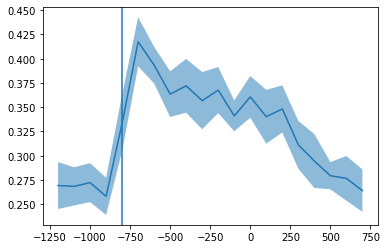

In [33]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    test_accs_by_bin,
    1200, 800, 100,
    ax,
)
ax.axvline(-800, color='k')

In [31]:
test_accs_by_bin = np.load("../data/accs_by_bin_random_splitter.npy")